## Vision Transformers

In this notebook, we will define and implement the Vision Transformer model. 

# Data Loading and Preprocessing
In this section, we will load the CIFAR-10 dataset and perform basic preprocessing. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes. We will apply the following preprocessing steps:
- Resize images to 32x32 pixels.
- Normalize the pixel values to a range of [-1, 1].
- Visualize some sample images from the dataset.


Files already downloaded and verified
Files already downloaded and verified


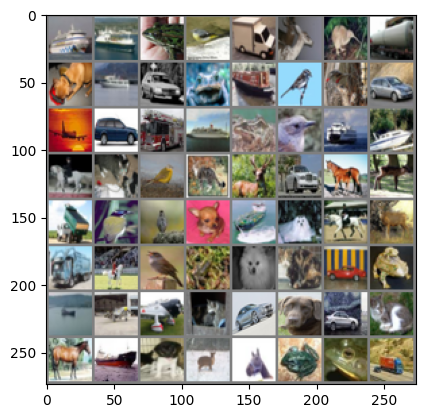

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to visualize sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


# Patch Embedding
The PatchEmbed class is defined to split the input images into smaller patches and embed these patches into vectors. This process involves:
- Dividing each 32x32 image into 4x4 patches.
- Using a convolutional layer to project these patches into a lower-dimensional embedding space.
- Flattening the patches and rearranging them for further processing in the transformer model.

<img src="img/ViT-arch-embed.png" alt="Alt Text" width="500">


In [49]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x
    


In [50]:
def show_patches(img, patch_size):
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format for visualization
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.set_title(f'{patch_size}x{patch_size} Patches')
    ax.axis('off')

    # Draw the grid
    for i in range(0, img.shape[0], patch_size):
        for j in range(0, img.shape[1], patch_size):
            rect = plt.Rectangle((j, i), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


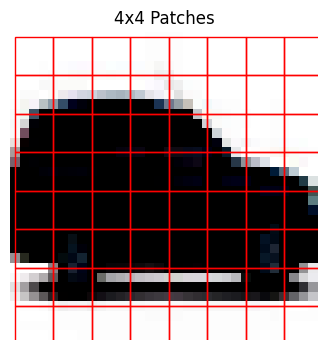

In [51]:
img_no=17
example_image = images[img_no]  # Use one image from your dataset
show_patches(example_image, patch_size=4)

# Visulization of patch embeddings

In [52]:
def show_embedded_patch_vector(image, patch_embed, patch_index):
    # Apply the patch embedding
    patches = patch_embed(image.unsqueeze(0))  # Add batch dimension
    patches = patches.squeeze(0)  # Remove batch dimension

    # Select the specified patch
    patch_vector = patches[patch_index]

    # Print the vector
    print(f"Patch {patch_index} vector (size {patch_vector.size()}):\n{patch_vector}")
    #print(f"Patch {patch_index} vector:\n{patch_vector}")

# Example usage
example_image = images[img_no]  # Use one image from your dataset
patch_embed = PatchEmbed(img_size=32, patch_size=4, in_chans=3, embed_dim=64)
show_embedded_patch_vector(example_image, patch_embed, patch_index=img_no)

Patch 17 vector (size torch.Size([64])):
tensor([ 0.1268, -0.1001,  0.2995,  0.0028,  0.1455, -0.1402, -0.1205, -0.4169,
         0.1534, -0.2738,  0.1564,  0.0353,  0.1061,  0.2806,  0.3609,  0.2760,
         0.0928,  0.2274, -0.1654, -0.2552, -0.1306, -0.0435,  0.1394,  0.0060,
        -0.3076,  0.0421,  0.0908,  0.0133,  0.1859, -0.1813, -0.1682,  0.1264,
        -0.2257,  0.0164, -0.1716,  0.2062,  0.1780, -0.4811, -0.2073, -0.2526,
         0.0116, -0.5219,  0.0391, -0.0983,  0.3853,  0.1324,  0.2001,  0.2413,
        -0.1963, -0.0908, -0.0956,  0.2526,  0.2809, -0.3387,  0.0624, -0.2163,
         0.1449,  0.2788,  0.1246, -0.1295,  0.1458, -0.1665,  0.2383, -0.2580],
       grad_fn=<SelectBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patches shape: torch.Size([1, 64, 64])


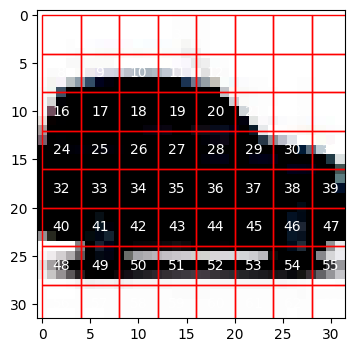

In [53]:
def show_patches_with_numbers(img, patch_size, stride):
    img = img.numpy().transpose(1, 2, 0)
    fig, ax = plt.subplots(figsize=(4, 4))
    patch_id = 0
    for i in range(0, img.shape[0]- patch_size + 1, stride):
        for j in range(0, img.shape[1]- patch_size + 1, stride):
            rect = plt.Rectangle((j, i), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(j + patch_size // 2, i + patch_size // 2, str(patch_id), color='white', ha='center', va='center')
            patch_id += 1
    ax.imshow(img)
    plt.show()

# Example of Patch Embedding
patch_embed = PatchEmbed()
example_image = images[img_no].unsqueeze(0)  # Use one image
patches = patch_embed(example_image)
print(f'Patches shape: {patches.shape}')
show_patches_with_numbers(images[img_no], 4,4)

# Positional Encoding
The PositionalEncoding class adds positional information to the embedded patches. This step is crucial because the transformer model does not inherently understand the order or positions of the patches. By adding positional encodings, we provide the model with information about the spatial relationships between the patches.

<img src="img/ViT-arch-embed.png" alt="Alt Text" width="500">

In [54]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        #self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02)  # Initialize with small random values

    def forward(self, x):
        x = x + self.pos_embed[:, :x.size(1), :]
        return x
    def visualize_positional_encoding(self):
        pos_enc = self.pos_embed.detach().cpu().numpy().squeeze(0)
        plt.imshow(pos_enc, cmap='viridis')
        plt.title('Positional Encodings')
        plt.colorbar()
        plt.show()



64


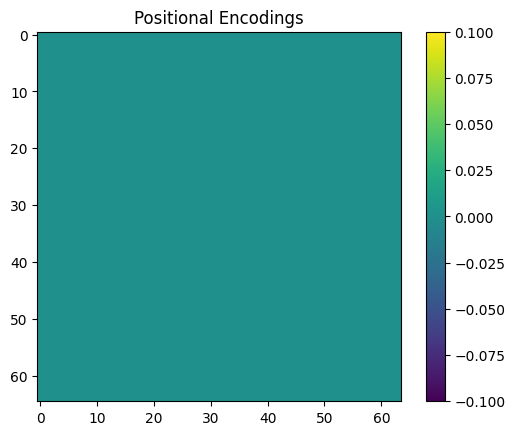

In [55]:
# Example usage
num_patches = patch_embed.num_patches
print(num_patches)
pos_enc = PositionalEncoding(embed_dim=64, num_patches=num_patches)
pos_enc.visualize_positional_encoding()

# Self-Attention
The SelfAttention class implements the self-attention mechanism. Self-attention allows each patch to attend to all other patches within the same image. The steps involved are similar to standard attention but are applied within the same sequence of patches:
- Projects the input patches into queries, keys, and values.
- Computes the attention scores and weights.
- Computes the weighted sum of the values.
- Projects the result back to the original embedding dimension.

<img src="img/ViT-arch-attention.png" alt="Alt Text" width="500">


In [56]:

class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None  # To store attention weights

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale # dot product of Q and K
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()  # Save attention weights

        x = (attn @ v).transpose(1, 2).reshape(B, N, C) # use attention to compute weighted V
        x = self.proj(x) # back to embedding dimension
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


# Cross-Attention
The CrossAttention class demonstrates how patches from a query image can attend to patches from a key and value image, which is useful in encoder-decoder architectures. The process includes:
- Projecting the query image patches into queries.
- Projecting the key and value image patches into keys and values.
- Computing the attention scores and weights between the queries and keys.
- Computing the weighted sum of the values based on the attention weights.
- Projecting the result back to the original embedding dimension.


In [57]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.kv_proj = nn.Linear(embed_dim, embed_dim * 2)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, q, k, v):
        B, N, C = q.shape
        q = self.q_proj(q).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k, v = self.kv_proj(k).reshape(B, -1, self.num_heads, 2, self.head_dim).permute(3, 0, 2, 1, 4).unbind(0)

        attn_weights = (q @ k.transpose(-2, -1)) * self.scale
        attn_weights = attn_weights.softmax(dim=-1)

        out = (attn_weights @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out, attn_weights

    def visualize_attention(self, q, k, img, layer_num):
        B, N, C = q.shape
        q = self.q_proj(q).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k, v = self.kv_proj(k).reshape(B, -1, self.num_heads, 2, self.head_dim).permute(3, 0, 2, 1, 4).unbind(0)

        attn_weights = (q @ k.transpose(-2, -1)) * self.scale
        attn_weights = attn_weights.softmax(dim=-1).detach().cpu().numpy()

        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()

# Masked Attention
The MaskedAttention class is used to mask certain patches during the attention computation. This is particularly useful in autoregressive models where future patches should not be attended to. The process involves:
- Projecting the input patches into queries, keys, and values.
- Applying a mask to the attention scores to prevent certain patches from attending to others.
- Computing the attention weights and applying the mask.
- Computing the weighted sum of the values based on the masked attention weights.
- Projecting the result back to the original embedding dimension.


In [58]:
class MaskedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MaskedAttention, self).__init__()
        self.num_heads = num_heads
        self.scale = embed_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_weights = None

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

    def visualize_attention(self, img, layer_num):
        fig, ax = plt.subplots(1, self.num_heads + 1, figsize=(20, 5))
        ax[0].imshow(img.numpy().transpose(1, 2, 0))
        ax[0].set_title('Original Image with Patch Numbers')
        patch_id = 0
        for i in range(0, img.shape[1], 4):
            for j in range(0, img.shape[2], 4):
                rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
                patch_id += 1

        for i in range(self.num_heads):
            sns.heatmap(self.attn_weights[layer_num, i], ax=ax[i + 1], cbar=True)
            ax[i + 1].set_title(f'Head {i + 1}')
        plt.show()


# Multi-Layer Perceptron (MLP)
The MLP class defines a simple feed-forward neural network with two layers. This is typically used in the Vision Transformer after the attention mechanism to process the output embeddings:
- The first layer applies a linear transformation followed by a GELU activation.
- Dropout is applied to prevent overfitting.
- The second layer applies another linear transformation.

<img src="img/vit_all_tran.png" alt="Alt Text" width="200">

In [59]:
class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.act = nn.GELU() # Gaussian Error Linear Unit
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x



# Transformer Block
The TransformerBlock class combines the self-attention mechanism and the MLP to form a single transformer block. It also includes layer normalization and residual connections.



In [60]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = Attention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer (ViT)
The VisionTransformer class integrates all the components (patch embedding, positional encoding, attention, and MLP) to build the complete Vision Transformer model. The process includes:
- Embedding the input image patches.
- Adding positional encodings to the embedded patches.
- Passing the embedded patches through multiple layers of attention and MLP (Transformer Blocks).
- Applying a classification head to predict the output class.


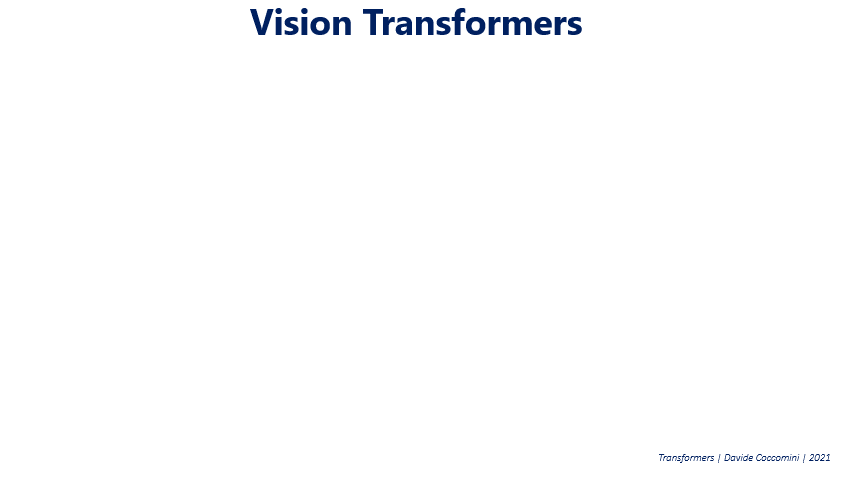

In [61]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=64, depth=6, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        print(f"Number of patches: {num_patches}")
        self.pos_embed = PositionalEncoding(embed_dim=embed_dim, num_patches=num_patches)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, int(embed_dim * mlp_ratio))
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim) # normalization before classification head
        self.head = nn.Linear(embed_dim, num_classes) # final embedinngs to number of classes

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1) # to match the batch size
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_embed(x)
        for block in self.transformer:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0] # only the first token
        x = self.head(cls_token_final)
        return x

# Create the Vision Transformer model
vit_model = VisionTransformer()

# Get a sample image
example_image = images[8].unsqueeze(0)  # Use one image

# Forward pass through the model to generate attention weights
output = vit_model(example_image)

# Visualize the attention maps from a specific layer and head
#vit_model.blocks[0].attn.visualize_attention(images[8], layer_num=0)


Number of patches: 64


In [62]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = VisionTransformer().to(device).float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).float()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

train_model(model, train_loader, criterion, optimizer, num_epochs=2)

def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).float()
    acc = running_corrects / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(model, test_loader)


Number of patches: 64


Epoch 0/1, Loss: 2.0046, Acc: 0.2329
Epoch 1/1, Loss: 1.8431, Acc: 0.3027
Test Accuracy: 0.3120


# Let's see what it has learned

In [63]:
def visualize_patch_embeddings(image, patch_embed):
    image=image.to(device)
    # Apply the patch embedding
    patches = patch_embed(image.unsqueeze(0))  # Add batch dimension
    patches = patches.squeeze(0)  # Remove batch dimension

    # Select the first patch for visualization
    patch_vector = patches[0]

    # Print the vector and its size
    print(f"First patch vector (size {patch_vector.size()}):\n{patch_vector}")

def visualize_positional_encodings(pos_enc):
    pos_enc.visualize_positional_encoding()

def visualize_attention(model, image, layer_num=0, device='cpu'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        x = model.patch_embed(image.unsqueeze(0))
        cls_tokens = model.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = model.pos_embed(x)
        for i, block in enumerate(model.transformer):
            x = block(x)
            if i == layer_num:
                attn_weights = block.attn.attn_weights
                break

    num_heads = model.transformer[layer_num].attn.num_heads
    fig, ax = plt.subplots(2, num_heads // 2 + 1, figsize=(20, 10))
    ax[0, 0].imshow(image.permute(1, 2, 0).cpu().numpy())
    ax[0, 0].set_title('Original Image with Patch Numbers')
    patch_id = 0
    for i in range(0, image.shape[1], 4):
        for j in range(0, image.shape[2], 4):
            rect = plt.Rectangle((j, i), 4, 4, edgecolor='r', facecolor='none')
            ax[0, 0].add_patch(rect)
            ax[0, 0].text(j + 4 // 2, i + 4 // 2, str(patch_id), color='white', ha='center', va='center')
            patch_id += 1

    for i in range(num_heads):
        row = i // 4
        col = (i % 4) + 1
        sns.heatmap(attn_weights[layer_num, i], ax=ax[row, col], cbar=True)
        ax[row, col].set_title(f'Head {i + 1}')
    plt.show()

First patch vector (size torch.Size([64])):
tensor([ -20.8966,  -91.3274,  -72.2663,  -87.4945,  -69.5939,  -43.3596,
         -59.9522,  -86.9545,  -51.9714,  -96.3842, -103.9830,  -97.3752,
        -104.2733,  -85.3739,  -74.0861,  -61.5575,  -64.0538,  -98.4806,
        -125.7548, -105.5050, -123.1652, -100.2944,  -64.8285,  -63.3121,
        -103.4001,  -73.9020,  -82.8555,  -94.0013,  -86.4898,  -62.7521,
        -100.4907,  -83.0405,  -99.7377,  -86.3739, -120.9978,  -99.9717,
        -124.3418,  -92.0476,  -90.7244,  -62.4863, -109.2452, -109.7539,
        -124.5518, -104.3534,  -95.3123, -102.9252,  -91.3851, -103.6008,
         -86.1347,  -85.9860, -107.5058, -105.7978,  -82.5520,  -65.7464,
        -115.9306,  -72.1203,  -90.3190,  -99.1993,  -52.9404,  -82.9895,
         -52.1565,  -62.0540,  -91.9280, -130.4531], device='mps:0',
       grad_fn=<SelectBackward0>)


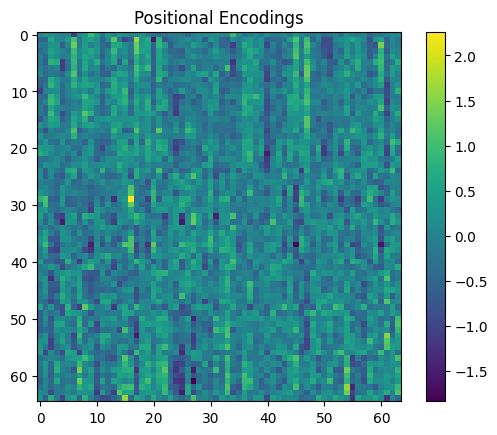

In [64]:
example_image = images[img_no]
# Visualize patch embeddings
visualize_patch_embeddings(example_image, model.patch_embed)

# Visualize positional encodings
visualize_positional_encodings(model.pos_embed)

# Visualize attention weights


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


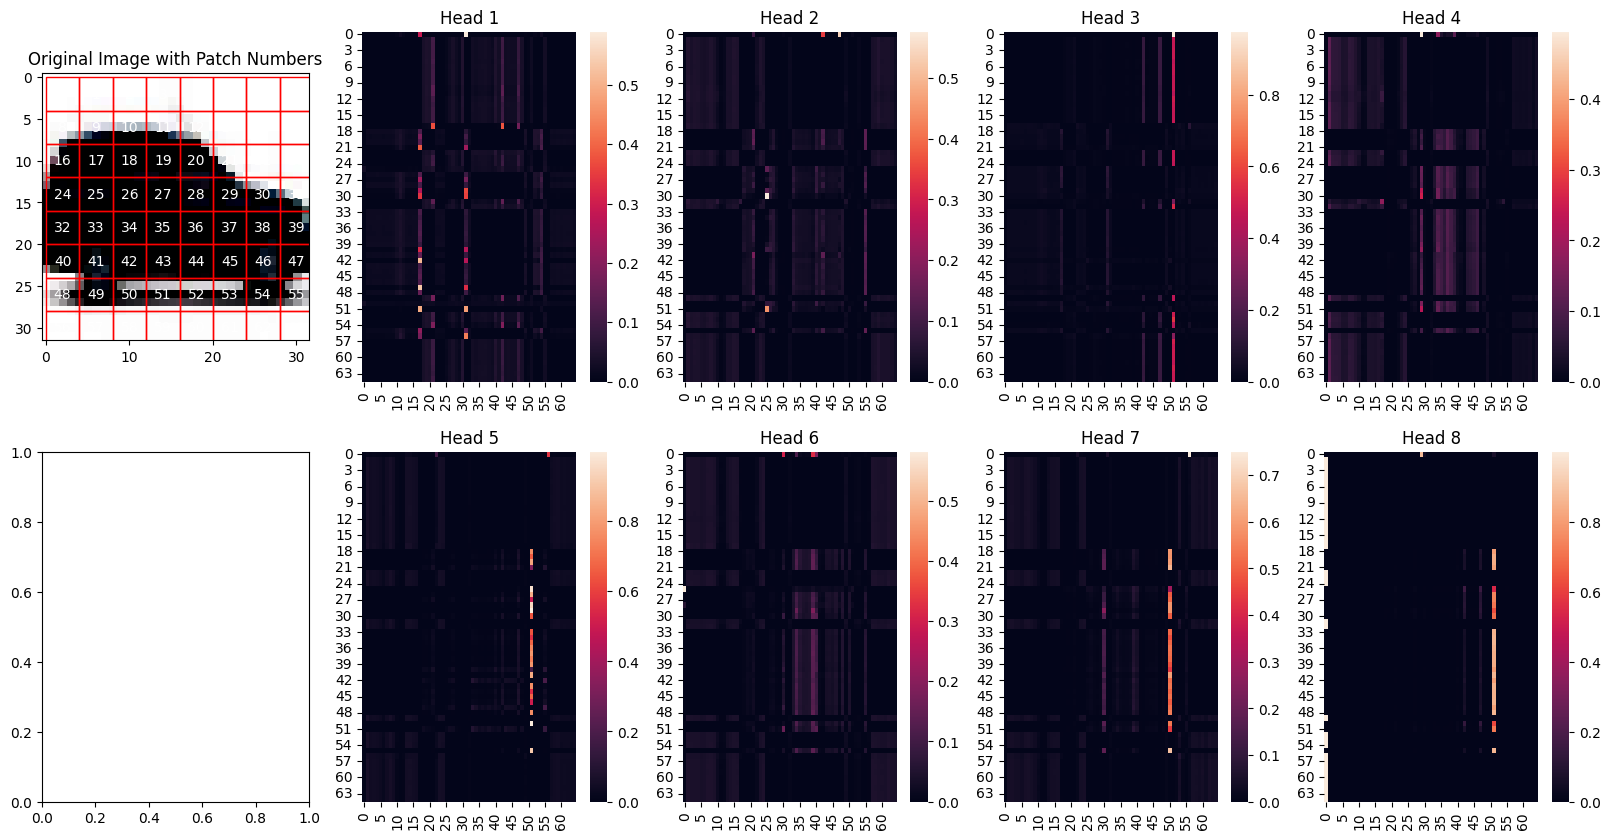

In [65]:
visualize_attention(model, example_image, layer_num=0)